In [1]:
# Makes the display take up more of the screen
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))

In [2]:
import numpy as np
import pandas as pd
import math
import sys
import cv2

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

In [3]:
from sympy import *
import structure

In [4]:
from scipy.spatial.transform import Rotation as Rot

In [93]:
import Transformations as trnsfrm

/home/stev/anaconda3/exp/Fusion/Transformations.py:1668: UserWarning: failed to import module _transformations
  warnings.warn("failed to import module " + module_name)


In [5]:
import os
os.path.abspath(os.getcwd())

'/home/stev/anaconda3/exp/Fusion'

In [218]:
%reload_ext autoreload
%autoreload 2
import collections, itertools

import time, sys
from scipy import sparse

import scipy.linalg

from transforms3d.euler import mat2euler
from pathlib import Path
import gc

In [6]:
""" ********INITIALIZATION PARAMETERS********  """

INITIAL_DEPTH_ESTIMATE = 0.5

INIT_X = 0
INIT_Y = 0
INIT_Z = 0

QUAT_INIT_REAL = 1
QUAT_INIT_I = 0
QUAT_INIT_J = 0
QUAT_INIT_K = 0

INIT_V_X = 0
INIT_V_Y = 0
INIT_V_Z = 0

INIT_OMEGA_X = 0.1
INIT_OMEGA_Y = 0.1
INIT_OMEGA_Z = 0.1

MAX_LINEAR_VELOCITY=1
MAX_ANGULAR_VELOCITY=1

In [7]:
path='Wadham'

files=np.sort([o.name for o in os.scandir(path)])
files

array(['001.jpg', '002.jpg', '003.jpg', '004.jpg', '005.jpg'], dtype='<U7')

In [248]:
def find_correspondence_points(img1, img2):
    sift = cv2.xfeatures2d.SIFT_create()
    #sift = cv2.SIFT()

    # find the keypoints and descriptors with SIFT
    kp1, des1 = sift.detectAndCompute(
        cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY), None)
    kp2, des2 = sift.detectAndCompute(
        cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY), None)

    # Find point matches
    FLANN_INDEX_KDTREE = 0
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(des1, des2, k=2)

    # Apply Lowe's SIFT matching ratio test
    good = []
    for m, n in matches:
        if m.distance < 0.8 * n.distance:
            good.append(m)

    src_pts = np.asarray([kp1[m.queryIdx].pt for m in good])
    dst_pts = np.asarray([kp2[m.trainIdx].pt for m in good])

    # Constrain matches to fit homography
    retval, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 100.0)
    mask = mask.ravel()

    # We select only inlier points
    pts1 = src_pts[mask == 1]
    pts2 = dst_pts[mask == 1]

    return pts1.T, pts2.T

In [249]:
def cart2hom(arr):
    """ Convert catesian to homogenous points by appending a row of 1s
    :param arr: array of shape (num_dimension x num_points)
    :returns: array of shape ((num_dimension+1) x num_points) 
    """
    if arr.ndim == 1:
        return np.hstack([arr, 1])
    return np.asarray(np.vstack([arr, np.ones(arr.shape[1])]))

In [250]:
i=0
filepath1=f'{path}/{files[i]}'
filepath2=f'{path}/{files[i+1]}'

/home/stev/anaconda3/envs/fusion/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


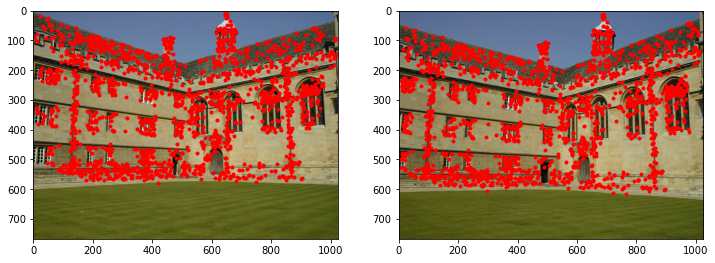

In [251]:
img1 = cv2.imread(filepath1)
img2 = cv2.imread(filepath2)
pts1, pts2 = find_correspondence_points(img1, img2)
points1 = cart2hom(pts1)
points2 = cart2hom(pts2)

fig, ax = plt.subplots(1, 2,  figsize=(12,7))
ax[0].autoscale_view('tight')
ax[0].imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
ax[0].plot(points1[0], points1[1], 'r.')
ax[1].autoscale_view('tight')
ax[1].imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
ax[1].plot(points2[0], points2[1], 'r.')
fig.show()

height, width, ch = img1.shape
intrinsic = np.array([  # for dino
    [2360, 0, width / 2],
    [0, 2360, height / 2],
    [0, 0, 1]])

In [252]:
pts1.shape, points1.shape

((2, 1786), (3, 1786))

In [253]:
# Calculate essential matrix with 2d points.
# Result will be up to a scale
# First, normalize points
points1n = np.dot(np.linalg.inv(intrinsic), points1)
points2n = np.dot(np.linalg.inv(intrinsic), points2)

In [254]:
def compute_normalized_image_to_image_matrix(p1, p2, compute_essential=False):
    """ Computes the fundamental or essential matrix from corresponding points
        using the normalized 8 point algorithm.
    :input p1, p2: corresponding points with shape 3 x n
    :returns: fundamental or essential matrix with shape 3 x 3
    """
    n = p1.shape[1]
    if p2.shape[1] != n:
        raise ValueError('Number of points do not match.')

    # preprocess image coordinates
    p1n, T1 = scale_and_translate_points(p1)
    p2n, T2 = scale_and_translate_points(p2)

    # compute F or E with the coordinates
    F = compute_image_to_image_matrix(p1n, p2n, compute_essential)

    # reverse preprocessing of coordinates
    # We know that P1' E P2 = 0
    F = np.dot(T1.T, np.dot(F, T2))

    return F / F[2, 2]

In [255]:
def compute_essential_normalized(p1, p2):
    return compute_normalized_image_to_image_matrix(p1, p2, compute_essential=True)

In [256]:
# calculate essential matrix
E = structure.compute_essential_normalized(points1n, points2n)
print('Computed essential matrix:')

T=Matrix(-E / E[0][1]);T

Computed essential matrix:


Matrix([
[-0.0589907260392625,               -1.0,  -0.156049886340496],
[  0.480380383302623, -0.138135382219302,   -1.48033597824033],
[  0.160001703904884,   1.39541464210249, -0.0142187596499893]])

In [257]:
R1,R2,t = cv2.decomposeEssentialMat(E)

In [258]:
R1, R2, t

(array([[ 0.57815413, -0.13902795,  0.80399567],
        [-0.19637908, -0.98012051, -0.02826727],
        [ 0.79194259, -0.14154509, -0.5939629 ]]),
 array([[ 0.95648235, -0.0317005 , -0.29006308],
        [ 0.02420541,  0.99927485, -0.02939176],
        [ 0.29078448,  0.02109161,  0.95655608]]),
 array([[ 0.81369282],
        [-0.09128969],
        [ 0.57408204]]))

In [259]:
Rot.from_matrix(R1).as_quat()

array([ 0.88772709, -0.09445668,  0.44944507, -0.03190108])

In [260]:
# Given we are at camera 1, calculate the parameters for camera 2
# Using the essential matrix returns 4 possible camera paramters
P1 = np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0]])
P2s = structure.compute_P_from_essential(E)

In [261]:
P2s

[array([[ 0.57815413, -0.13902795,  0.80399567,  0.81369282],
        [-0.19637908, -0.98012051, -0.02826727, -0.09128969],
        [ 0.79194259, -0.14154509, -0.5939629 ,  0.57408204]]),
 array([[ 0.57815413, -0.13902795,  0.80399567, -0.81369282],
        [-0.19637908, -0.98012051, -0.02826727,  0.09128969],
        [ 0.79194259, -0.14154509, -0.5939629 , -0.57408204]]),
 array([[ 0.95648235, -0.0317005 , -0.29006308,  0.81369282],
        [ 0.02420541,  0.99927485, -0.02939176, -0.09128969],
        [ 0.29078448,  0.02109161,  0.95655608,  0.57408204]]),
 array([[ 0.95648235, -0.0317005 , -0.29006308, -0.81369282],
        [ 0.02420541,  0.99927485, -0.02939176,  0.09128969],
        [ 0.29078448,  0.02109161,  0.95655608, -0.57408204]])]

In [262]:
def compare2Images(filepath1,filepath2, ShowImages=False):
    img1 = cv2.imread(filepath1)
    img2 = cv2.imread(filepath2)
    pts1, pts2 = find_correspondence_points(img1, img2)
    points1 = cart2hom(pts1)
    points2 = cart2hom(pts2)
    if ShowImages==True:
        fig, ax = plt.subplots(1, 2,  figsize=(12,7))
        ax[0].autoscale_view('tight')
        ax[0].imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
        ax[0].plot(points1[0], points1[1], 'r.')
        ax[1].autoscale_view('tight')
        ax[1].imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
        ax[1].plot(points2[0], points2[1], 'r.')
        fig.show()
    
    height, width, ch = img1.shape
    intrinsic = np.array([  # for dino
        [2360, 0, width / 2],
        [0, 2360, height / 2],
        [0, 0, 1]])
    return points1, points2, intrinsic

/home/stev/anaconda3/envs/fusion/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  from ipykernel import kernelapp as app


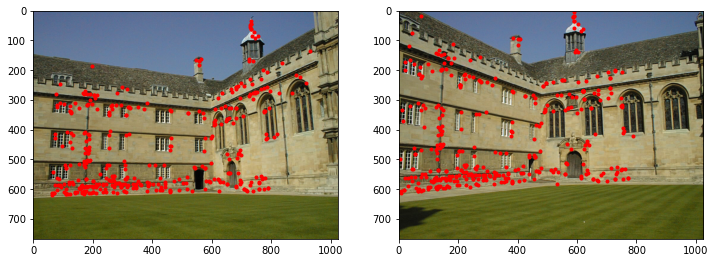

In [263]:
i=2
filepath1=f'{path}/{files[i]}'
filepath2=f'{path}/{files[i+1]}'

points1, points2, intrinsic= compare2Images(filepath1,filepath2, ShowImages=True)

In [264]:
n_features=300

/home/stev/anaconda3/envs/fusion/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  from ipykernel import kernelapp as app
/home/stev/anaconda3/envs/fusion/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  from ipykernel import kernelapp as app
/home/stev/anaconda3/envs/fusion/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  from ipykernel import kernelapp as app
/home/stev/anaconda3/envs/fusion/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, 

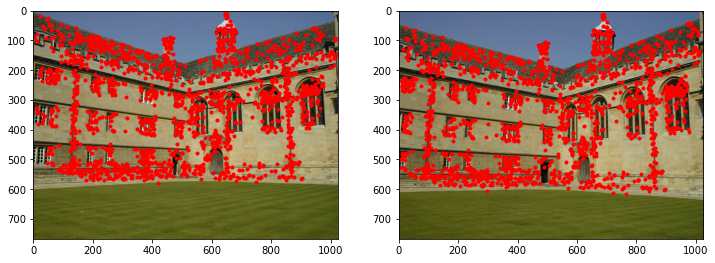

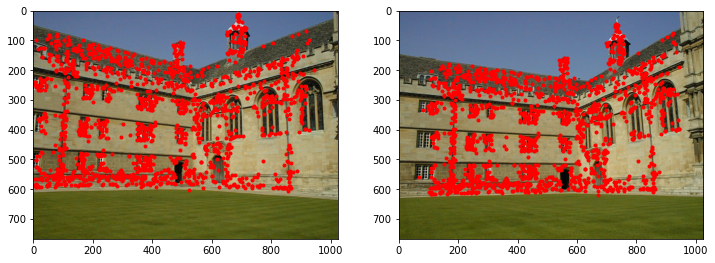

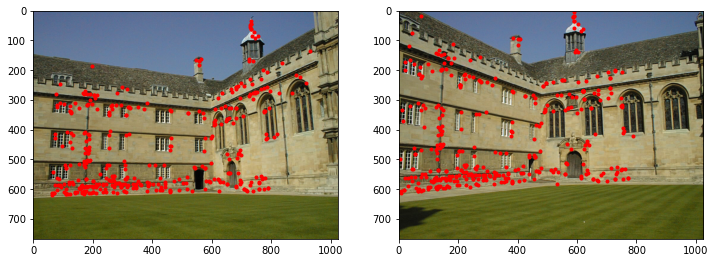

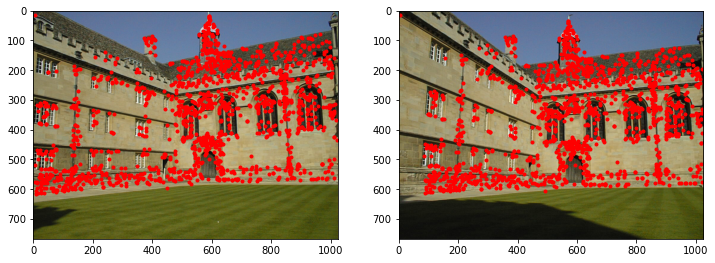

In [265]:
rot_lst=[]
pos=[]
pnt_lst=[]
for i in range(len(files)-1):
    #print(i)
    filepath1=f'{path}/{files[i]}'
    filepath2=f'{path}/{files[i+1]}'
    
    points1, points2, intrinsic= compare2Images(filepath1,filepath2, ShowImages=True)

    points1n = np.dot(np.linalg.inv(intrinsic), points1)
    points2n = np.dot(np.linalg.inv(intrinsic), points2)
    
    E = structure.compute_essential_normalized(points1n, points2n)
    
    pnt_lst.append([points1n[0][:n_features],points1n[1][:n_features],points2n[0][:n_features],points2n[1][:n_features] ])
    
    R1,R2,t = cv2.decomposeEssentialMat(E)

    if i==0: 
        rot_lst.append(R1)
        pos.append(np.array([0, 0, 0]))
    rot_lst.append(R2)
    pos.append(t.T[0])
    
pos=np.array(pos)
rot_lst=np.array(rot_lst)
pnt_lst=np.array(pnt_lst)

In [266]:
pnt_lst.shape

(4, 4, 300)

In [267]:
i=0
R=rot_lst[i]
p=pos[i]
H0=np.r_[np.c_[R, p], [[0, 0, 0, 1]]]

i=1
R=rot_lst[i]
p=pos[i]
H1=np.r_[np.c_[R, p], [[0, 0, 0, 1]]]

i=2
R=rot_lst[i]
p=pos[i]
H2=np.r_[np.c_[R, p], [[0, 0, 0, 1]]]

i=3
R=rot_lst[i]
p=pos[i]
H3=np.r_[np.c_[R, p], [[0, 0, 0, 1]]]

In [268]:
i=4
R=rot_lst[i]
p=pos[i]
H4=np.r_[np.c_[R, p], [[0, 0, 0, 1]]]

In [269]:
Matrix(H0)

Matrix([
[ 0.578154126529649, -0.139027945593017,   0.803995669342145, 0.0],
[-0.196379079143944,  -0.98012051221641, -0.0282672744922303, 0.0],
[ 0.791942588355567,   -0.1415450877877,  -0.593962898565101, 0.0],
[               0.0,                0.0,                 0.0, 1.0]])

In [270]:
Matrix(H1)

Matrix([
[ 0.956482350197364, -0.0317004960085564,  -0.290063083334881,   0.813692819716525],
[0.0242054054485314,   0.999274848400004, -0.0293917624891997, -0.0912896859645635],
[ 0.290784477075374,  0.0210916075243404,   0.956556078849557,   0.574082039762839],
[               0.0,                 0.0,                 0.0,                 1.0]])

In [271]:
Matrix(H2)

Matrix([
[ 0.762932211140119, -0.394392651658713,   0.512239082384835,  0.900988961094314],
[-0.462324451421768, -0.886691262785622, 0.00589118979494671, -0.199949262109021],
[ 0.451874476843304, -0.241315231216864,   -0.85882269203855,  0.385018421076508],
[               0.0,                0.0,                 0.0,                1.0]])

In [272]:
Matrix(H3)

Matrix([
[ 0.465796108815025, 0.0683340782285129,   0.882249646509105,  0.967567881828851],
[-0.120542662119682,  0.992619844043183, -0.0132405370279149,  -0.17582588364498],
[-0.876643286418074, -0.100181330418132,   0.470595632591051, -0.181377100797461],
[               0.0,                0.0,                 0.0,                1.0]])

In [273]:
Matrix(H4)

Matrix([
[  -0.40708377187619, -0.0833163561467827, -0.909582974485272, -0.512503552054266],
[-0.0637230212435026,  -0.990814088374202,  0.119276229160711,  0.072369742070709],
[  -0.91116528645392,   0.106516792467764,  0.398035166390767,  0.855630019087911],
[                0.0,                 0.0,                0.0,                1.0]])

In [274]:
def plotCamera(ax, R, t, c, scale):
    """Plot the camera in 3D
    Args:
        ax (Axis3D): target axis
        R: 3x3 c2w rotation matrix
        t: 3x1 c2w translation vector
        c: color string
        scale: scaling factor
    """
    if t.shape[0] != 1:
        t = t.T

    ps_c = np.array(([0,0,0], [1,1,3], [1,-1,3], [-1,-1,3], [-1,1,3]))
    ps_w = (scale * R @ ps_c.T + t.T).T

    L01 = np.array([ps_w[0], ps_w[1]])
    L02 = np.array([ps_w[0], ps_w[2]])
    L03 = np.array([ps_w[0], ps_w[3]])
    L04 = np.array([ps_w[0], ps_w[4]])
    L1234 = np.array([ps_w[1], ps_w[2], ps_w[3], ps_w[4], ps_w[1]])
    ax.plot(L01[:,0], L01[:,1], L01[:,2], "-", color=c)
    ax.plot(L02[:,0], L02[:,1], L02[:,2], "-", color=c)
    ax.plot(L03[:,0], L03[:,1], L03[:,2], "-", color=c)
    ax.plot(L04[:,0], L04[:,1], L04[:,2], "-", color=c)
    ax.plot(L1234[:,0], L1234[:,1], L1234[:,2], "-", color=c)

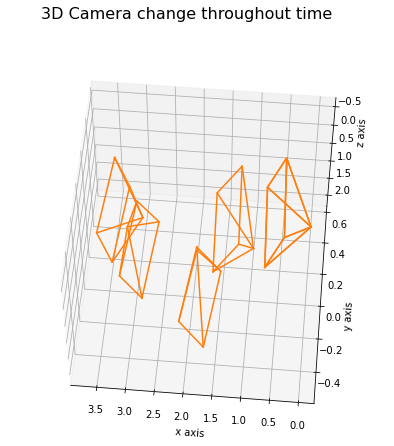

In [275]:
fig = plt.figure(figsize=(12,7))
fig.suptitle('3D Camera change throughout time', fontsize=16)
ax = fig.gca(projection='3d')
#ax.plot(pos[:,0], pos[:,1], pos[:,2], 'k.')

scale=0.25
c='#ff7f0e'
#plotaxis(H0*scale)
#plotaxis((H0@H1)*scale)
#plotaxis((H0@H1@H2)*scale)
#plotaxis((H0@H1@H2@H3)*scale)
#plotaxis((H0@H1@H2@H3@H4)*scale)

H=H0
plotCamera(ax, R=H[:3,:3], t=np.array([H[:3,3]]).T, c=c, scale=scale)

H=H0@H1
plotCamera(ax, R=H[:3,:3], t=np.array([H[:3,3]]).T, c=c, scale=scale)

H=H0@H1@H2
plotCamera(ax, R=H[:3,:3], t=np.array([H[:3,3]]).T, c=c, scale=scale)

H=H0@H1@H2@H3
plotCamera(ax, R=H[:3,:3], t=np.array([H[:3,3]]).T, c=c, scale=scale)

H=H0@H1@H2@H3@H4
plotCamera(ax, R=H[:3,:3], t=np.array([H[:3,3]]).T, c=c, scale=scale)

H=H0
plotCamera(ax, R=H[:3,:3], t=np.array([H[:3,3]]).T, c=c, scale=scale)

ax.set_xlabel('x axis')
ax.set_ylabel('y axis')
ax.set_zlabel('z axis')
ax.view_init(elev=-125, azim=85)
plt.show()

In [276]:
#t: time stamp with shape 1*t 
# features: visual feature point coordinates in stereo images with shape 4*n*t, where n is number of features
# linear_velocity: IMU measurements in IMU frame with shape 3*t
# rotational_velocity: IMU measurements in IMU frame with shape 3*t
# K: (left)camera intrinsic matrix with shape 3*3
#              [fx  0 cx
#                0 fy cy
#                0  0  1]      
# b: stereo camera baseline with shape 1
# cam_T_imu: extrinsic matrix from IMU to (left)camera, in SE(3) with shape 4*4 
#            ~ [ 0 -1  0 t1
#                0  0 -1 t2
#                1  0  0 t3
#                0  0  0  1]
t_max=len(files)
t=np.array([t for t in range(t_max-1)]) # (5)
features= pnt_lst.reshape(4,n_features,t_max-1)                  #(4, X, t_max)
linear_velocity=   np.random.normal(0.5, 0.1, size=(3,t_max-1))   # (3,t_max)      
rotational_velocity= np.random.normal(0.5, 0.1, size=(3,t_max-1)) # (3,t_max)
K= intrinsic
b=1  
cam_T_imu = np.array([ [ 9.98747206e-04, -9.99990382e-01,  4.25937849e-03, 1.08330198e+00],
                       [ 8.41690183e-03, -4.25082114e-03, -9.99955570e-01, -3.09888901e-01],
                       [ 9.99964049e-01,  1.03455328e-03,  8.41257521e-03,  7.29919795e-01],
                       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  1.00000000e+00]])#(4,4)
t=t.reshape(1,t.shape[0])
final_xlim, final_ylim = None, None

In [278]:
pnt_lst.shape

(4, 4, 300)

In [279]:
def wedge(x):
    assert x.size in [3, 6]
    x = x.reshape(-1)
    if x.size == 3:
        return np.array([[0, -x[2], x[1]], [x[2], 0, -x[0]], [-x[1], x[0], 0]])
    elif x.size == 6:
        return np.block([[wedge(x[3:]), x[:3].reshape(-1, 1)], [np.array([0, 0, 0, 0])]])


def cwedge(x):
    assert x.size == 6
    x = x.reshape(-1)
    return np.block([[wedge(x[3:]), wedge(x[:3])], [np.zeros((3, 3)), wedge(x[3:])]])


def cdot(x):
    x = x.reshape(-1)
    assert x.size == 4 and x[-1] == 1
    return np.block([[np.eye(3), -wedge(x[:3])], [np.zeros((1, 6))]])


def pi(q):
    assert q.ndim == 2 and q.shape[0] == 4
    return q / q[2, :]


def dpidq(q):
    assert q.size == 4
    q = q.reshape(-1)
    return (1 / q[2]) * np.array([[1, 0, -q[0] / q[2], 0], [0, 1, -q[1] / q[2], 0], [0, 0, 0, 0],
                                  [0, 0, -q[3] / q[2], 1]])

In [280]:
def visualize_trajectory_2d(pose,
                            landmarks=None,
                            initialized=None,
                            observed=None,
                            xlim=None,
                            ylim=None,
                            figsize=20,
                            save_fig_name=None,
                            show_start_end=True,
                            show_navigation=False,
                            show_ori=False):
    PATH_COLOR = '#ff4733'
    LANDMARK_COLOR = '#59b359'
    LANDMARK_OBSERVED_COLOR = '#0067ff'
    NAVIGATION_COLOR = '#3888ff'

    fig, ax = plt.subplots(figsize=(figsize, figsize))
    n_pose = pose.shape[2]

    ax.plot(pose[0, 3, :], pose[1, 3, :], '-', color=PATH_COLOR, linewidth=2)
    if landmarks is not None:
        n_landmarks = landmarks.shape[0]
        initialized = initialized.copy() if initialized is not None else np.ones(n_landmarks, dtype=bool)
        observed = observed.copy() if observed is not None else np.zeros(n_landmarks, dtype=bool)

        initialized[observed] = False

        ax.scatter(landmarks[initialized, 0],
                   landmarks[initialized, 1],
                   s=10.0,
                   color=LANDMARK_COLOR,
                   marker='o',
                   linewidths=0.1)
        ax.scatter(landmarks[observed, 0],
                   landmarks[observed, 1],
                   s=10.0,
                   color=LANDMARK_OBSERVED_COLOR,
                   marker='o',
                   linewidths=0.1)

    if show_start_end:
        ax.scatter(pose[0, 3, 0], pose[1, 3, 0], color='red', marker='s', label="start")
        ax.scatter(pose[0, 3, -1], pose[1, 3, -1], color='blue', marker='o', label="end")

    if show_ori:
        select_ori_index = list(range(0, n_pose, max(int(n_pose / 10), 1)))
        yaw_list = []
        for i in select_ori_index:
            _, _, yaw = mat2euler(pose[:3, :3, i])
            yaw_list.append(yaw)
        dx = np.cos(yaw_list)
        dy = np.sin(yaw_list)
        dx, dy = [dx, dy] / np.sqrt(dx**2 + dy**2)
        ax.quiver(pose[0,3,select_ori_index],pose[1,3,select_ori_index],dx,dy,\
            color="b",units="xy",width=1)

    if show_navigation:
        dx, dy = 0, 0
        for i in range(2, n_pose + 1):
            if dx**2 + dy**2 > 1:
                break
            else:
                dx = np.average(pose[0, 3, -1] - pose[0, 3, -i:-1])
                dy = np.average(pose[1, 3, -1] - pose[1, 3, -i:-1])

        x, y = pose[0, 3, -1], pose[1, 3, -1]
        plt.arrow(x,
                  y,
                  dx,
                  dy,
                  length_includes_head=True,
                  head_width=10,
                  head_starts_at_zero=True,
                  overhang=0.2,
                  zorder=999,
                  facecolor=NAVIGATION_COLOR,
                  edgecolor='black')

    plt.axis('equal')
    # plt.axis('off')
    ax.grid(False)
    # ax.legend()

    if xlim:
        ax.set_xlim(xlim)
    if ylim:
        ax.set_ylim(ylim)

    if save_fig_name:
        Path(os.path.dirname(save_fig_name)).mkdir(parents=True, exist_ok=True)
        plt.savefig(save_fig_name, bbox_inches='tight')
        # Clear the current figure.
        plt.clf()
        # Closes all the figure windows.
        plt.close('all')
        plt.close(fig)
        del fig
        del ax
        gc.collect()
        return None, None
    else:
        plt.show(block=True)
        return fig, ax

In [281]:
class EKFSLAM:

    def __init__(self,
                 n_landmarks,
                 robot_cam_T_imu,
                 robot_cam_intrinsic_calib,
                 robot_cam_baseline,
                 process_noise_covariance=None,
                 observation_noise_covariance=None,
                 prior_pose_covariance=None,
                 prior_landmark_covariance=None):

        if prior_landmark_covariance is None:
            prior_landmark_covariance = 5e-3 * np.eye(3)
        if prior_pose_covariance is None:
            prior_pose_covariance = 1e-3 * np.eye(6)
        if observation_noise_covariance is None:
            observation_noise_covariance = 100 * np.eye(4)
        if process_noise_covariance is None:
            process_noise_covariance = 1e-3 * np.eye(6)

        self.xU = np.eye(4)
        self.W = process_noise_covariance

        self.n_landmarks = n_landmarks

        self._n_initialized = 0
        self._initialized_maxid = 0
        self._initialized_mask = np.zeros((n_landmarks), dtype=bool)

        self.xm = np.zeros((n_landmarks, 3))

        self.P = np.block([[prior_pose_covariance, np.zeros((6, 3 * n_landmarks))],
                           [np.zeros((3 * n_landmarks, 6)),
                            np.kron(np.eye(n_landmarks), prior_landmark_covariance)]])
        self.V = observation_noise_covariance

        self.oTi = robot_cam_T_imu

        K = robot_cam_intrinsic_calib
        self.b = robot_cam_baseline
        self.M = np.block([[K[:2, :], np.array([[0, 0]]).T], [K[:2, :], np.array([[-K[0, 0] * self.b, 0]]).T]])

    @property
    def initialized_maxid(self):
        return self._initialized_maxid

    @property
    def n_initialized(self):
        return self._n_initialized

    @property
    def is_initialized(self):
        return self._initialized_mask

    @property
    def xUp(self):
        return self.xU[:3, 3].reshape(-1, 1)

    @property
    def oTw(self):
        return self.oTi @ self.xU

    def predict(self, u, tau):
        F = scipy.linalg.expm(-tau * wedge(u))
        self.xU = F @ self.xU

        F = scipy.linalg.expm(-tau * cwedge(u))
        self.P[:6, :] = F @ self.P[:6, :]
        self.P[:, :6] = self.P[:, :6] @ F.T

        self.P[:6, :6] += self.W

    def _make_zmap(self, z):
        assert z.ndim == 2 and z.shape[0] == 4
        return np.array(np.where(z.sum(axis=0) > -4), dtype=np.int32).reshape(-1)

    def _init_landmark(self, z, zmap):
        mask = np.invert(self._initialized_mask[zmap])
        zmap = zmap[mask]
        if zmap.size > 0:
            wTo = np.linalg.inv(self.oTw)
            self._initialized_mask[zmap] = True
            z = z[:, zmap]

            M = self.M
            b = self.b
            wcoord = np.ones((4, zmap.size))
            wcoord[0, :] = (z[0, :] - M[0, 2]) * b / (z[0, :] - z[2, :])
            wcoord[1, :] = (z[1, :] - M[1, 2]) * (-M[2, 3]) / (M[1, 1] * (z[0, :] - z[2, :]))
            wcoord[2, :] = -M[2, 3] / (z[0, :] - z[2, :])
            wcoord = wTo @ wcoord
            self.xm[zmap, :] = wcoord[:3, :].T

            self._n_initialized = np.sum(self._initialized_mask)
            self._initialized_maxid = max(zmap.max() + 1, self._initialized_maxid)

    def _make_H(self, z, zmap):
        n_observations = zmap.size
        n_updates = self._initialized_maxid

        P = np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0]], dtype=np.float64)

        xm = np.hstack([self.xm[zmap, :], np.ones((n_observations, 1))])
        H = np.zeros((n_observations * 4, n_updates * 3 + 6))

        for i in range(n_observations):
            obi = zmap[i]

            H[i * 4:(i + 1) * 4,
              6 + obi * 3:6 + (obi + 1) * 3] = self.M @ dpidq(self.oTw @ xm[i, :].reshape(-1, 1)) @ self.oTw @ P.T

        # Prepare observation matrix for odometry
        for i in range(n_observations):
            H[i * 4:(i + 1) * 4, :6] = self.M @ dpidq(self.oTw @ xm[i, :].reshape(-1, 1)) @ self.oTi @ cdot(
                self.xU @ xm[i, :].reshape(-1, 1))

        return H

    def _make_xm_P(self, z, zmap):
        n_observations = zmap.size
        n_updates = self._initialized_maxid

        xm = self.xm[:n_updates, :]
        P = self.P[:6 + n_updates * 3, :6 + n_updates * 3]

        return xm, P

    def _make_z(self, z, zmap):
        return z[:, zmap].reshape(-1, 1, order='F')

    def _make_predicted_z(self, z, zmap):
        n_observations = zmap.size

        xm = np.hstack([self.xm[zmap, :], np.ones((n_observations, 1))])
        zp = self.M @ pi(self.oTw @ xm.T)
        return zp.reshape(-1, 1, order='F')

    def _update_value_xm_P(self, xm, P, zmap):
        n_observations = zmap.size
        n_updates = self._initialized_maxid

        self.xm[:n_updates, :] = xm
        self.P[:6 + n_updates * 3, :6 + n_updates * 3] = P

    def update(self, z):
        zmap = self._make_zmap(z)
        if zmap.size > 0:
            n_observations = zmap.size
            self._init_landmark(z, zmap)

            H = self._make_H(z, zmap)
            xm, P = self._make_xm_P(z, zmap)
            zp = self._make_predicted_z(z, zmap)
            z = self._make_z(z, zmap)

            V = np.kron(np.eye(n_observations), self.V)
            PHT = P @ H.T
            K = np.linalg.solve((H @ PHT + V).T, PHT.T).T
            # K = PHT @ np.linalg.inv(H @ PHT + V)

            mean_update = K @ (z - zp)
            xm += mean_update[6:, 0].reshape(-1, 3)
            P = (np.eye(K.shape[0]) - K @ H) @ P

            self.xU = scipy.linalg.expm(wedge(mean_update[:6, 0])) @ self.xU
            self._update_value_xm_P(xm, P, zmap)
        return zmap

------------ 1 ----------------------
INITIALIZED LANDMARK::: 300
TIME COST:: 0.07
------------ 2 ----------------------
INITIALIZED LANDMARK::: 300
TIME COST:: 0.06
------------ 3 ----------------------
INITIALIZED LANDMARK::: 300
TIME COST:: 0.06


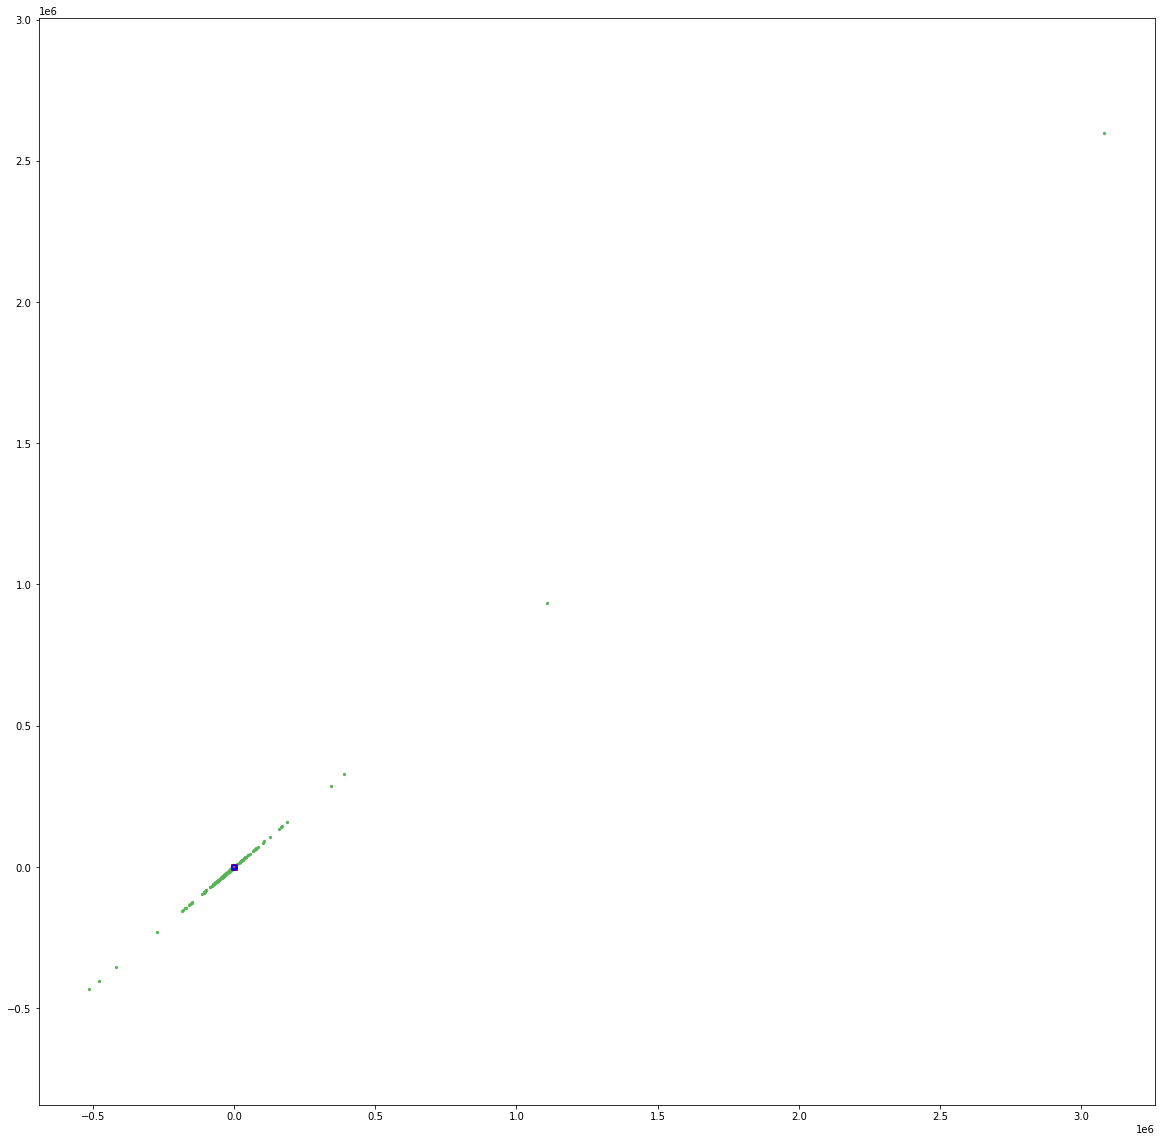

(<Figure size 1440x1440 with 1 Axes>, <AxesSubplot:>)

In [282]:
ekf = EKFSLAM(
    n_landmarks=features.shape[1],
    robot_cam_T_imu=cam_T_imu,
    robot_cam_intrinsic_calib=K,
    robot_cam_baseline=b,
    observation_noise_covariance= 100 * np.eye(4),
    prior_landmark_covariance= 5e-3 * np.eye(3),
    process_noise_covariance= 1e-3 * np.eye(6)
)


u = np.vstack([linear_velocity, rotational_velocity])
T = linear_velocity.shape[-1]
pose = []

for i in range(1, T):
    ekf.predict(u[:, i], (t[0, i] - t[0, i-1]))
    start = time.time()
    zmap = ekf.update(features[:, :, i])
    pose.append(np.linalg.inv(ekf.xU))
    end = time.time()

    if i % 1 == 0:
        print(f'------------ {i} ----------------------')
        print('INITIALIZED LANDMARK:::', ekf.n_initialized)
        print('TIME COST::', round(end - start, 2))
    
    if (i + 1) % 5 == 0:
        visualize_trajectory_2d(np.stack(pose, -1), 
                                landmarks=ekf.xm,
                                initialized=ekf.is_initialized,
                                observed=zmap,
                                save_fig_name=f'./fig/0027/{i}.jpg',
                                xlim=final_xlim,
                                ylim=final_ylim,
                                show_navigation=True)

pose = np.stack(pose, -1) if isinstance(pose, list) else pose
visualize_trajectory_2d(pose, ekf.xm, show_ori=True)